<a href="https://colab.research.google.com/github/Aditya-11/Reinforcement_Learning_based_Algorithmic_Trading-Al/blob/master/stock_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# environment 

import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import itertools

# Intelligent Stock Trading Agent
# Agent : Deep Q network 


"""
3 stock trading env 

(State_Space) ->  # of stock owned, current stock prices, cash in hand

- array of length n_stock*2 + 1
- price is discretized (to integer) to reduce state space
- use close price for each stock
- cash in hand is evaluated at each step based on action performed


(Action_Space) -> sell (0)
               -> hold (1)
               -> and buy (2)

when selling, sell all the shares
when buying, buy as many as cash in hand allows
if buying multiple stock, equally distribute cash in hand and then utilize the balance
"""

class Trade_env(gym.Env):
  def __init__(self,train_data, init_invest):
    self.stock_price_history = train_data
    self.n_stock = self.stock_price_history.shape[0]
    self.n_step = self.stock_price_history[0].shape
    print("n_step",self.n_step)
    self.init_invest = init_invest
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    # action space
    self.action_space = spaces.Discrete(3**self.n_stock)


    # observation space: give estimates in order to sample and build scaler
    sm1 = self.stock_price_history[0][:].max()
    sm2 = self.stock_price_history[1][:].max()
    sm3 = self.stock_price_history[2][:].max()

    stock_max_price = [sm1,sm2,sm3]
    
    stock_range = [[0, init_invest * 2 // mx] for mx in stock_max_price]
    price_range = [[0, mx] for mx in stock_max_price]
    cash_in_hand_range = [[0, init_invest * 2]]
    
    stock_range = [[int(i) for i in stock_range[0]]]
    price_range = [[int(i) for i in price_range[0]]]
    cash_in_hand_range = [[int(i) for i in cash_in_hand_range[0]]]
    self.observation_space = spaces.MultiDiscrete([18,118,2001])

    self._seed()
    self._reset()

  def _seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def _reset(self):
    self.cur_step = 0
    self.stock_owned = [0] * self.n_stock
    self.stock_price = [self.stock_price_history[i][self.cur_step] for i in range(3)]
    self.cash_in_hand = self.init_invest
    return self._get_obs()

  def _step(self, action):
    assert self.action_space.contains(action)
    prev_val = self._get_val()
    self.cur_step += 1
    self.stock_price = [self.stock_price_history[i][self.cur_step-1] for i in range(3)]
    self._trade(action)
    cur_val = self._get_val()
    reward = cur_val - prev_val
    if (self.cur_step == self.n_step[0]-2):
      done = True
    else :
      done = False
    info = {'cur_val': cur_val}
    return self._get_obs(), reward, done, info

  def _get_obs(self):
    obs = []
    obs.extend(self.stock_owned)
    obs.extend(list(self.stock_price))
    obs.append(self.cash_in_hand)
    return obs

  def  _get_val(self):
    return np.sum(np.array(self.stock_owned) * np.array(self.stock_price)) + self.cash_in_hand

  def _trade(self, action):
    # all combo to sell(0), hold(1), or buy(2) stocks
    action_combo = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))
    action_vec = action_combo[action]

    # one pass to get sell/buy index
    sell_index = []
    buy_index = []
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)
    
        # two passes: sell first, then buy; might be naive in real-world settings
    if sell_index:
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0

    if buy_index:
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False

In [ ]:
!pip install tensorflow

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def get_data(col='close'):
  msft = pd.read_csv('daily_MSFT.csv', usecols=[col])
  ibm = pd.read_csv('daily_IBM.csv', usecols=[col])
  qcom = pd.read_csv('daily_QCOM.csv', usecols=[col])


  msft = msft.iloc[1:2000]
  ibm = msft.iloc[1:2000]
  qcom = qcom.iloc[1:2000]
  return np.array([msft[col].values[::-1],
                   ibm[col].values[::-1],
                   qcom[col].values[::-1]])


def get_scaler(env):
  low = [0] * (env.n_stock * 2 + 1)

  high = []
  max_price = [env.stock_price_history[i][:].max() for i in range(3)]
  min_price = [env.stock_price_history[i][:].min() for i in range(3)]

  max_cash = env.init_invest * 3 

  max_stock_owned = [max_cash//min_price[i] for i in range(3)]

  for i in max_stock_owned:
    high.append(i)
  for i in max_price:
    high.append(i)
  high.append(max_cash)

  scaler = StandardScaler()
  scaler.fit([low, high])
  return scaler


In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from collections import deque

import numpy as np

import random


class Stock_Agent:
  def __init__(self, state_size ,action_size , batch_size):
    self.action = action_size
    self.states = state_size
    self.memory = deque(maxlen = 10000)
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.99995
    self.batch_size = batch_size
    self.model = self._model() 
    print(self.model.summary())
    print("action size -> " , action_size)

  def _model(self):
    model = Sequential()
    model.add(Dense(units=32, input_shape=(1,),activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(self.action, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.0019))
    return model

  def model_load_weight(self):
    checkpoint_path = 'dqtrader.h5'
    self.model.load_weights(checkpoint_path)
  
  def remember(self,state,action,reward,next_state,done):
    self.memory.append((state,action,reward,next_state,done))

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action)
    
    options = self.model.predict(state)
    return np.argmax(options[0])
  
  def test_act(self,state):
    options = self.model.predict(state)
    return np.argmax(options[0]) 
  
  def experience_replay(self):
    if (len(self.memory) < self.batch_size):
      return 
    else: 
      batch = random.sample(self.memory,self.batch_size)
      
      for state,action,reward,next_state,terminate in batch:
        q_update = reward
        if not terminate:
          next_state = np.array([next_state]).T
          q_update = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
          
        q_values = self.model.predict(state)
        q_values[0][action] = q_update
        self.model.fit(state,q_values,verbose=0)
      
        if (self.epsilon > self.epsilon_min):
            self.epsilon = self.epsilon * self.epsilon_decay

In [ ]:
# Train the agent
import pickle
import time
import numpy as np
import argparse
import re

no_episode = 50
batch_size = 30
timestamp = time.strftime('%Y%m%d%H%M')
data = get_data()
train_data = data
print(train_data[0].shape)
env = Trade_env(train_data,1000)
state_size = 7
action_size = env.action_space.n

print("state -> ",state_size)
print("action -> ",action_size)

agent = Stock_Agent(state_size,action_size,batch_size)
scaler = get_scaler(env)
portfolio_value = []


with tf.device('/gpu:0'):
  for e in range(no_episode):
    print("Episode no -> ", e)
    state = env._reset()
    state = scaler.transform([state])[0]
    for time in range(env.n_step[0]):
      action = agent.act(state)
      next_state, reward, done, info = env._step(action)
      next_state = scaler.transform([next_state])[0]

      agent.remember(state, action, reward, next_state, done)
      state = next_state
      if done or env.cur_step == 4523:
        print("episode: {}/{}, episode end value: {}".format(e + 1, no_episode, info['cur_val']))
        portfolio_value.append(info['cur_val']) 
        break
      if len(agent.memory) > batch_size:
        agent.experience_replay()


In [ ]:
print(portfolio_value)

[1743.0801000000044, 945.5701000000049, 2005.1329999999973, 1270.9854000000018, 2788.632299999988, 3451.5199999999704, 1334.2071999999996, 2405.980400000014, 2224.856400000014, 1770.2369000000062, 1747.3451999999743, 1843.2011999999945, 1753.8225000000243, 1866.1704000000072, 3624.9520000000143, 1983.7980000000007, 2052.0232999999985, 1066.2345000000007, 1227.8528999999987, 2110.037000000002, 1755.2739999999988, 1584.0900000000092, 2760.0670000000023, 1259.1324999999977, 3009.7410000000064, 4304.612200000009, 2015.9799999999996, 2721.753000000001, 3089.1525000000047, 3058.527499999982, 1150.0970000000016, 2764.650000000004, 2543.199599999999, 2740.317499999992, 1523.0596000000032, 2296.4341999999956, 1302.1314999999997, 1107.0628000000008, 3974.050999999995, 2450.0750000000007, 2418.8084000000003, 2571.544999999996, 3463.3791000000024, 1755.4900000000018, 2847.842, 2851.9900000000007, 3097.615800000001, 2658.4199999999946, 3025.2000000000003, 1646.8869999999984]


In [ ]:
agent.model.save('dqtrader.h5')
from google.colab import files
files.download('dqtrader.h5')

Text(0, 0.5, 'value')

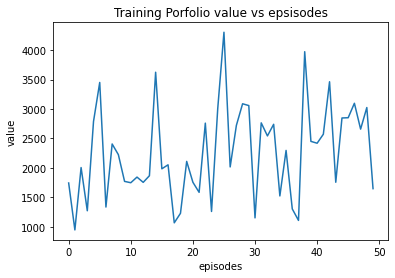

In [ ]:
import matplotlib.pyplot as plt
x = [1743.0801000000044, 945.5701000000049, 2005.1329999999973, 1270.9854000000018, 2788.632299999988, 3451.5199999999704, 1334.2071999999996, 2405.980400000014, 2224.856400000014, 1770.2369000000062, 1747.3451999999743, 1843.2011999999945, 1753.8225000000243, 1866.1704000000072, 3624.9520000000143, 1983.7980000000007, 2052.0232999999985, 1066.2345000000007, 1227.8528999999987, 2110.037000000002, 1755.2739999999988, 1584.0900000000092, 2760.0670000000023, 1259.1324999999977, 3009.7410000000064, 4304.612200000009, 2015.9799999999996, 2721.753000000001, 3089.1525000000047, 3058.527499999982, 1150.0970000000016, 2764.650000000004, 2543.199599999999, 2740.317499999992, 1523.0596000000032, 2296.4341999999956, 1302.1314999999997, 1107.0628000000008, 3974.050999999995, 2450.0750000000007, 2418.8084000000003, 2571.544999999996, 3463.3791000000024, 1755.4900000000018, 2847.842, 2851.9900000000007, 3097.615800000001, 2658.4199999999946, 3025.2000000000003, 1646.8869999999984]
plt.plot(range(50),x)
plt.title("Training Porfolio value vs epsisodes")
plt.xlabel("episodes")
plt.ylabel("value")

In [ ]:
#Testing the model on data

# Test the model for next 1000 days
Test_no = 1

col = 'close'

msft = pd.read_csv('daily_MSFT.csv', usecols=[col])
ibm = pd.read_csv('daily_IBM.csv', usecols=[col])
qcom = pd.read_csv('daily_QCOM.csv', usecols=[col])

msft = msft.iloc[3500:4000]
ibm = ibm.iloc[3500:4000]
qcom = qcom.iloc[3500:4000]

# recent price are at top; reverse it
test_data = np.array([msft[col].values[::-1],
                   ibm[col].values[::-1],
                   qcom[col].values[::-1]])
#print(test_data[1])

env = Trade_env(test_data,1000)

state_size = 7
action_size = env.action_space.n
batch_size = 30

# load the weights of the model
agent = Stock_Agent(state_size,action_size,batch_size)
#print(agent.stock_price_history.shape)
agent.model_load_weight()
scaler = get_scaler(env)


print(agent.model.summary())

for e in range(Test_no):
  print("Test_no no ->  ",e)
  state = env._reset()
  state = scaler.transform([state])[0]
  portfolio_val = []
  action_val = []
  for time in range(env.n_step[0]):
    action = agent.test_act(state)
    action_val.append(action)
    next_state, reward, done, info = env._step(action)
    portfolio_val.append(info['cur_val'])
    next_state = scaler.transform([next_state])[0]
    state = next_state



n_step (500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 27)                891       
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
None
action size ->  27
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056   

In [ ]:
print(portfolio_val)

[1000.0000000000002, 1007.6800000000003, 991.8400000000003, 1018.7200000000003, 1016.4800000000002, 993.2800000000002, 972.4800000000002, 988.0000000000002, 958.4000000000002, 957.4400000000003, 974.8800000000002, 966.4000000000002, 963.8400000000003, 963.0400000000003, 1011.5200000000002, 1042.4000000000003, 1038.8800000000003, 1047.6800000000003, 1033.1200000000003, 1052.8000000000004, 1059.0400000000004, 1030.2400000000002, 1023.2000000000003, 1009.1200000000002, 1029.4400000000003, 1023.8400000000003, 1025.2800000000002, 991.2000000000003, 1011.3600000000002, 996.8000000000003, 977.2800000000002, 974.8800000000002, 980.6400000000002, 994.5600000000003, 995.6800000000003, 946.0800000000003, 930.8800000000002, 932.8000000000003, 923.5200000000002, 945.1200000000002, 907.5200000000002, 930.4000000000002, 906.2400000000002, 924.4800000000002, 920.6400000000002, 954.5600000000003, 935.6800000000003, 931.5200000000002, 944.8000000000003, 919.0400000000003, 893.4400000000003, 877.92000000

Text(0, 0.5, 'value')

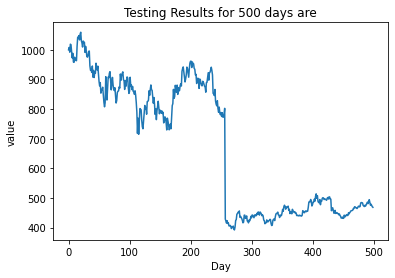

In [ ]:
# testing graph 

import matplotlib.pyplot as plt
x = portfolio_val
plt.plot(range(500),x)
plt.title("Testing Results for 500 days are")
plt.xlabel("Day")
plt.ylabel("value")
